In [1]:
from loadingCGAN.novgan_trafic_input import Novgan_trafic_input
from load_data.load_data import load_data
from utils.config_novgan_trafic_input import *
from loadingCGAN.utils_cgan import creating_dico_index
from time import time
import numpy as np
from loadingCGAN.utils_cgan import save_time

Using TensorFlow backend.


In [2]:
########
# DATA #
########
x_train, _, y_train, _, x_balanced_train, _, x_test, y_test, colnames = load_data(place=place,
                                                                                  attack_mode=attack_mode,
                                                                                  attack=attack,
                                                                                  nrows=nrows,
                                                                                  cv_size=cv_size,
                                                                                  log_transform=False,
                                                                                  shuffle=shuffle,
                                                                                  return_colnames=True)
x_train_bad = np.array([x for x, y in zip(x_train, y_train) if int(y) == 1])
x_train = np.array([x for x, y in zip(x_train, y_train) if int(y) == 0])

x_test_bad = np.array([x for x, y in zip(x_test, y_test) if int(y) == 1])
x_test = np.array([x for x, y in zip(x_test, y_test) if int(y) == 0])


if balanced_train_size is not None:
    x_balanced_train = x_balanced_train[:balanced_train_size]

data_dim = x_train.shape[1]
dico_index = creating_dico_index(colnames=colnames)

/home/peseux/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/peseux/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train data shape is (43058, 114)
Test data shape is (43058, 114)

  
 
 
  
 
 
Train data shape is (33006, 114)

  
 
 
  
 
 
x_train overview
   0         1         2    3    4    5    6    7    8    9    ...  104  105  \
0 -1.0 -0.999973 -0.997833 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0   
1 -1.0 -0.999971 -0.999632 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0   
2 -1.0 -1.000000 -1.000000 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0   
3 -1.0 -1.000000 -1.000000 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0   
4 -1.0 -1.000000 -1.000000 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0   

   106  107  108  109  110  111  112  113  
0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
1 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
2 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
3 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
4 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  

[5 rows x 114 columns]

  
 
 
  
 
 
y_train overview
     0
0  0.0
1  0.0
2  1.0
3  1.0
4  1.0

  
 
 
  
 

In [3]:
##########
# NovGan #
##########
novgan_trafic_input = Novgan_trafic_input(data_dim=data_dim, activation=activation, verbose=True,
                                          noise_dim=noise_dim,
                                          leaky_relu=leaky_relu, offset=offset, alpha=alpha, dropout=dropout,
                                          dico_index=dico_index,
                                          noise="normal",
                                          smooth_one=smooth_one,
                                          smooth_zero=smooth_zero, batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.
CHOSEN OPTIMIZER IS ADAM
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

 
 Generator Architecture 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                7936      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________________________________

# Epoch 0/50
Instructions for updating:
Use tf.cast instead.


/home/peseux/.local/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


# Epoch 1/50
# Epoch 2/50
# Epoch 3/50
# Epoch 4/50
# Epoch 5/50
# Epoch 6/50
# Epoch 7/50
# Epoch 8/50
# Epoch 9/50
# Epoch 10/50
# Epoch 11/50
# Epoch 12/50
# Epoch 13/50
# Epoch 14/50
# Epoch 15/50
# Epoch 16/50
# Epoch 17/50
# Epoch 18/50
# Epoch 19/50
# Epoch 20/50
# Epoch 21/50
# Epoch 22/50
# Epoch 23/50
# Epoch 24/50
# Epoch 25/50
# Epoch 26/50
# Epoch 27/50
# Epoch 28/50
# Epoch 29/50
# Epoch 30/50
# Epoch 31/50
# Epoch 32/50
# Epoch 33/50
# Epoch 34/50
# Epoch 35/50
# Epoch 36/50
# Epoch 37/50
# Epoch 38/50
# Epoch 39/50
# Epoch 40/50
# Epoch 41/50
# Epoch 42/50
# Epoch 43/50
# Epoch 44/50
# Epoch 45/50
# Epoch 46/50
# Epoch 47/50
# Epoch 48/50
# Epoch 49/50


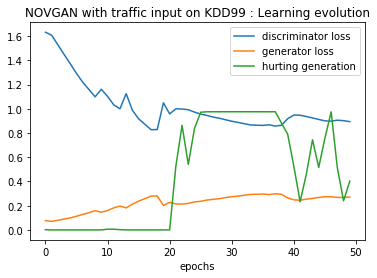

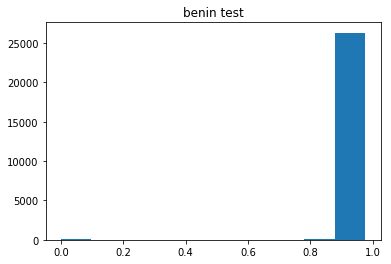

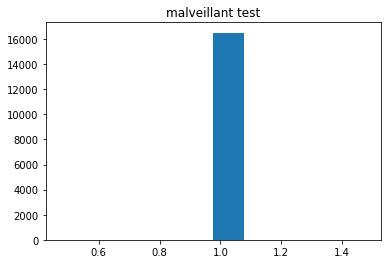

array([0.97572952, 0.97572952, 0.97572952, ..., 0.97572952, 0.97572952,
       0.97572952])

In [4]:
############
# Training #
############
start = time()
learned = novgan_trafic_input.train(x_train=x_train, epochs=epochs,
                                    x_train_bad=x_train_bad,
                                    print_recap=True)
end = time()
duration = end - start
save_time(duration=duration, location="tmp/", title=title)

novgan_trafic_input.hurting(x=x_test, title="benin test", print_mode=True)
novgan_trafic_input.hurting(x=x_test_bad, title="malveillant test", print_mode=True)

In [5]:
generated = novgan_trafic_input.generate(number=10000, x_bad=x_test[:1000])

In [6]:
from __future__ import print_function, division
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
from keras.initializers import glorot_uniform



leaky_relu = .1
auto_encoder  = Sequential()
auto_encoder.add(Dense(64,
                    input_dim=data_dim,
                    kernel_initializer=glorot_uniform()))
auto_encoder.add(LeakyReLU(leaky_relu))
auto_encoder.add(Dense(32))
auto_encoder.add(LeakyReLU(leaky_relu))
auto_encoder.add(BatchNormalization())
auto_encoder.add(Dense(64))
auto_encoder.add(LeakyReLU(leaky_relu))
auto_encoder.add(Dense(data_dim))
auto_encoder.compile(loss="mse",optimizer=Adam(0.0002, 0.5))
auto_encoder.fit(x_train, x_train, epochs=10, batch_size=128)
x_ae_test = auto_encoder.predict(x_test_bad)

Epoch 1/10
21241/21241 [==============================] - 1s 37us/step - loss: 0.5867
Epoch 2/10
21241/21241 [==============================] - 0s 12us/step - loss: 0.0881
Epoch 3/10
21241/21241 [==============================] - 0s 13us/step - loss: 0.0462
Epoch 4/10
21241/21241 [==============================] - 0s 14us/step - loss: 0.0375
Epoch 5/10
21241/21241 [==============================] - 0s 15us/step - loss: 0.0331
Epoch 6/10
21241/21241 [==============================] - 0s 18us/step - loss: 0.0307
Epoch 7/10
21241/21241 [==============================] - 0s 13us/step - loss: 0.0290
Epoch 8/10
21241/21241 [==============================] - 0s 16us/step - loss: 0.0260
Epoch 9/10
21241/21241 [==============================] - 0s 16us/step - loss: 0.0232
Epoch 10/10
21241/21241 [==============================] - 0s 17us/step - loss: 0.0219


In [7]:
x10 = auto_encoder.predict(x_test[:100].reshape(((100,114))))
x1 = auto_encoder.predict(x_test[0].reshape(((1,114))))

In [8]:
np.max(x1[0] - x10[0])

2.3841858e-07

In [9]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train)  

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
x_pca = pca.transform(x_train)
x_pca_gen = pca.transform(generated)
x_pca_ae = pca.transform(x_train_bad)

In [11]:
from matplotlib import pyplot as plt

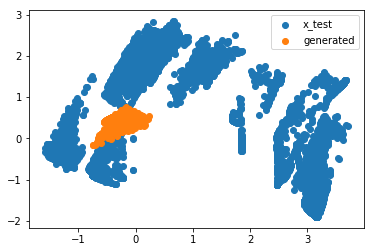

In [12]:
plt.scatter(x_pca[:,0].tolist(),x_pca[:,1].tolist(), label="x_test")
plt.scatter(x_pca_gen[:,0].tolist(),x_pca_gen[:,1].tolist(), label="generated")
# plt.scatter(x_pca_ae[:,0].tolist(),x_pca_ae[:,1].tolist(), label="auto_encoded")
plt.legend()
plt.show()
plt.close()

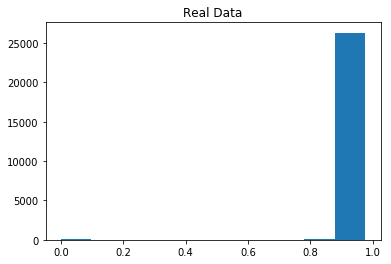

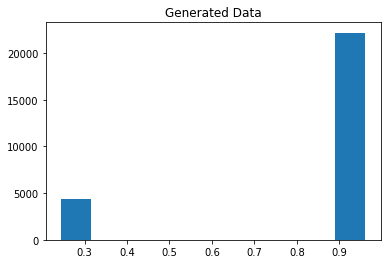

array([0.9364331 , 0.94895559, 0.24421557, ..., 0.95098205, 0.24421364,
       0.94639572])

In [13]:
############
# Plotting #
############
novgan_trafic_input.hurting(x=x_test, print_mode=True,title="Real Data")
novgan_trafic_input.hurting(x=novgan_trafic_input.generate(number=len(x_test), x_bad=x_test_bad[:len(x_test)]),
               print_mode=True,
               title="Generated Data")

In [14]:
noise = np.random.random(114).reshape((1,114))